# **Movie Recommendation using Spark ALS Recommender system**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.1.2-bin-hadoop3.2'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import col, avg, explode, lit, split
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

### Downloading One Million Movielens datasets from grouplens.org


In [ ]:
!wget -P /content/drive/MyDrive/Moviedataset https://files.grouplens.org/datasets/movielens/ml-1m.zip

--2021-09-14 18:22:34--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘/content/drive/MyDrive/Moviedataset/ml-1m.zip.38’

ml-1m.zip.38        100%[===================>]   5.64M  11.6MB/s    in 0.5s    

2021-09-14 18:22:35 (11.6 MB/s) - ‘/content/drive/MyDrive/Moviedataset/ml-1m.zip.38’ saved [5917549/5917549]



In [ ]:
!unzip /content/drive/MyDrive/Moviedataset/ml-1m.zip

Archive:  /content/drive/MyDrive/Moviedataset/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


#### Lets take a quick glance at the contens of the 'ratings.dat' file

In [ ]:
## Lets look at the contents of the 'ratings' file

sc = spark.sparkContext
raw_ratings = sc.textFile('/content/ml-1m/ratings.dat')
lines_ratings = raw_ratings.takeSample(False, 10, 0)

for line in lines_ratings:
  print(line)

5485::912::5::959833835
2190::2700::4::974606999
5193::1959::3::961701959
42::2140::3::978040305
5580::419::3::996164651
3367::926::5::970080990
2539::1036::4::974045750
1422::3368::3::976139738
3232::2607::4::968384802
3389::1732::3::967513393


####  The 'ratings' file follows the 'userId::movieId::ratings::timeStamp' format. Lets convert the 'ratings' file into a DataFrame using Spark DataFrame API.

In [ ]:
ratingSchema = StructType([\
                           StructField('userId', IntegerType(), True), \
                           StructField('movieId', IntegerType(), True), \
                           StructField('ratings', IntegerType(), True), \
                           StructField('timeStamp', LongType(), True)])                      
                           
ratings = spark.read.option('sep','::').schema(ratingSchema).csv('/content/ml-1m/ratings.dat')               


In [ ]:
##lets create the 'ratings' DataFrame by choosing only 'userId', 'movieId', 'ratings' columns.

ratingsDF = ratings.select('userId', 'movieId', 'ratings').cache()
ratingsDF.sample(False, 0.0001, 0).show(10)

+------+-------+-------+
|userId|movieId|ratings|
+------+-------+-------+
|    58|   2580|      4|
|   136|    235|      5|
|   187|    246|      5|
|   329|    832|      2|
|   368|   1370|      3|
|   629|   1013|      4|
|   660|   2409|      2|
|   662|     19|      3|
|   690|   1370|      5|
|   852|    480|      3|
+------+-------+-------+
only showing top 10 rows



In [ ]:
## lets also check the schema that we created for the ratingsDF

ratingsDF.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- ratings: integer (nullable = true)



#### Lets quickly go through the 'ratingsDF' dataFrame

In [ ]:
## Number of rows in the ratingsDF dataframe

total_rows = ratingsDF.count()

print("Number of rows in the ratingsDF: ", total_rows)

Number of rows in the ratingsDF:  1000209


In [ ]:
## Basic statistics like count, min, max, etc.. from the ratings dataset by running the describe() method..

ratingsDF.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|           movieId|           ratings|
+-------+------------------+------------------+------------------+
|  count|           1000209|           1000209|           1000209|
|   mean| 3024.512347919285|1865.5398981612843| 3.581564453029317|
| stddev|1728.4126948999626|1096.0406894572563|1.1171018453732653|
|    min|                 1|                 1|                 1|
|    max|              6040|              3952|                 5|
+-------+------------------+------------------+------------------+



In [ ]:
## Number of distinct users and movies from the ratings dataframe..

distinct_users = ratingsDF.select("userId").distinct().count()
distinct_movies = ratingsDF.select("movieId").distinct().count()

print("Number of distinct users from the ratings dataset : ", distinct_users)
print("Number of distinct movies from the ratings dataset : ", distinct_movies)

Number of distinct users from the ratings dataset :  6040
Number of distinct movies from the ratings dataset :  3706


In [ ]:
## sample of the Number of ratings per user

user_ratings = ratingsDF.groupBy("userId").count().withColumnRenamed('count', 'Total number of ratings')
user_ratings.show(10)

+------+-----------------------+
|userId|Total number of ratings|
+------+-----------------------+
|   148|                    624|
|   463|                    123|
|   471|                    105|
|   496|                    119|
|   833|                     21|
|  1088|                   1176|
|  1238|                     45|
|  1342|                     92|
|  1580|                     37|
|  1591|                    314|
+------+-----------------------+
only showing top 10 rows



In [ ]:
## function to calculate Sparsity of the ratingsDF 

def get_sparsity(ratingsDF):
  entries_ratingsDF = distinct_users * distinct_movies

  # to get sparsity, divide the Total number of rows by actual entries in the ratingsDf
  sparsity = (1.0 - (total_rows*1.0) / entries_ratingsDF) * 100.0
  
  print("The ratingsDF is %.2f " %sparsity+"% empty")


In [ ]:
## Lets check the Sparsity of the ratings dataframe

get_sparsity(ratingsDF)

The ratingsDF is 95.53 % empty


#### lets load the 'Movies' data file and look at its contents(sample)

In [ ]:
movies_raw = sc.textFile('/content/ml-1m/movies.dat')
lines_movies = movies_raw.takeSample(False, 10, 0)

for line in lines_movies:
  print(line)

258::Kid in King Arthur's Court, A (1995)::Adventure|Children's|Comedy|Fantasy|Romance
576::Fausto (1993)::Comedy
2914::Molly (1999)::Comedy|Drama
1579::For Ever Mozart (1996)::Drama
1571::When the Cats Away (Chacun cherche son chat) (1996)::Comedy|Romance
395::Desert Winds (1995)::Drama
30::Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)::Drama
721::Halfmoon (Paul Bowles - Halbmond) (1995)::Drama
1099::Christmas Carol, A (1938)::Drama
2796::Funny Farm (1988)::Comedy


#### Movies datafile follows the 'movieId', 'movieName', 'Genres' format. lets construct a schema to convert this movies datafile into a Spark dataFrame. 
 

In [ ]:
movieNameSchema = StructType([\
                              StructField("movieId", IntegerType(), True),\
                              StructField('movieName', StringType(), True), \
                              StructField("genres", StringType(), True)])
                          
movieNames = spark.read.option('sep', '::').schema(movieNameSchema).csv('/content/ml-1m/movies.dat')

movieNamesDF = movieNames.cache()

## showing the sample of 10 movies from the 'movieNames' DataFrame
movieNamesDF.sample(False, 0.01, 0).show(truncate=False)


+-------+--------------------------------------+-------------------------------+
|movieId|movieName                             |genres                         |
+-------+--------------------------------------+-------------------------------+
|10     |GoldenEye (1995)                      |Action|Adventure|Thriller      |
|172    |Johnny Mnemonic (1995)                |Action|Sci-Fi|Thriller         |
|254    |Jefferson in Paris (1995)             |Drama                          |
|413    |Airheads (1994)                       |Comedy                         |
|425    |Blue Sky (1994)                       |Drama|Romance                  |
|505    |North (1994)                          |Comedy                         |
|730    |Low Life, The (1994)                  |Drama                          |
|759    |Maya Lin: A Strong Clear Vision (1994)|Documentary                    |
|781    |Stealing Beauty (1996)                |Drama                          |
|839    |Crow: City of Angel

In [ ]:
## Number of entries in the movies dataframe..

print("Number of movies in the movieNamesDF: ", movieNamesDF.count())

Number of movies in the movieNamesDF:  3883


#### lets take a look at the 'Users' data file and sample its contents

In [ ]:
raw_users = sc.textFile('/content/ml-1m/users.dat')
lines_users = raw_users.takeSample(False, 10, 0)

for line in lines_users:
  print(line)

392::M::18::7::20037
1368::F::25::3::50266
2313::F::50::6::48103-4711
2163::M::18::0::87122
713::M::35::7::79912
30::F::35::7::19143
983::F::25::16::99224
6027::M::18::4::20742
3940::M::35::20::32708
1590::M::35::1::95003


#### User data file is in UserID::Gender::Age::Occupation::Zip-code format according to the README.txt provided by the 'grouplens.org'.
#### Lets create a schema to change the Users file to a spark dataFrame.

In [ ]:
UserSchema = StructType([\
                         StructField('userId', IntegerType(), True),\
                         StructField('gender', StringType(), True), \
                         StructField('age', IntegerType(), True), \
                         StructField('Occupation', IntegerType(), True), \
                         StructField('Zipcode', StringType(), True)                        
                        ])

userdata = spark.read.option('sep', '::').schema(UserSchema).csv('/content/ml-1m/users.dat')

#lets select userId, gender, age columns omitting Occupation and Zipcode for simplicity  
userDF = userdata.select('userId', 'gender', 'age').cache()

userDF.sample(False, 0.01, 0).show(10, truncate=False)

+------+------+---+
|userId|gender|age|
+------+------+---+
|10    |F     |35 |
|171   |F     |50 |
|252   |M     |25 |
|410   |F     |25 |
|422   |M     |56 |
|502   |M     |35 |
|722   |M     |25 |
|750   |F     |35 |
|772   |M     |18 |
|829   |M     |1  |
+------+------+---+
only showing top 10 rows



In [ ]:
## Basic statistics of User dataFrame..

userDF.describe().show()

+-------+------------------+------+------------------+
|summary|            userId|gender|               age|
+-------+------------------+------+------------------+
|  count|              6040|  6040|              6040|
|   mean|            3020.5|  null|30.639238410596025|
| stddev|1743.7421445462246|  null|12.895961726906837|
|    min|                 1|     F|                 1|
|    max|              6040|     M|                56|
+-------+------------------+------+------------------+



In [ ]:
## lets quickly go through the userDF dataFrame

#Number of distinct users in the users dataFrame
print('Number of users : {0}' . format(userDF.select('userId').distinct().count()))

#Number of Female users in the users dataFrame
userFemale = userDF.select('gender').where(userDF.gender == 'F').count()
print('Number of Females in the users dataFrame : {0}'. format(userFemale))

#Number of male users in the users dataFrame
userMale = userDF.select('gender').where(userDF.gender == 'M').count()
print('Number of males in the users dataFarme : {0}' . format(userMale))

#Number of users who are 18 yrs or more old
print('Number of users who are 18 yrs or older : {0}' . format(userDF.select('age').where(userDF.age >= 18).count()))

#Number of users who are less than 18 yrs 
print('Number of users who are less than 18 yrs : {0}' . format(userDF.select('age').where(userDF.age < 18).count()))



Number of users : 6040
Number of Females in the users dataFrame : 1709
Number of males in the users dataFarme : 4331
Number of users who are 18 yrs or older : 5818
Number of users who are less than 18 yrs : 222


## Exploratory Data Analysis of the MovieLens datasets
 

In [ ]:
## lets Join all Three dataframes(userDF, ratingsDF, movieNamesDF).. so we can do analysis on them.

fullDF = userDF.join(ratingsDF, userDF.userId == ratingsDF.userId, 'left')\
              .select(userDF.userId, userDF.gender, userDF.age, ratingsDF.movieId, ratingsDF.ratings)


fullDF = fullDF.join(movieNamesDF, fullDF.movieId == movieNamesDF.movieId, 'left') \
               .select(fullDF.userId, fullDF.gender, fullDF.age, fullDF.movieId, fullDF.ratings, movieNamesDF.movieName, movieNamesDF.genres)

fullDF.show(10, truncate=False)
               

+------+------+---+-------+-------+------------------------------------------+-----------------------------+
|userId|gender|age|movieId|ratings|movieName                                 |genres                       |
+------+------+---+-------+-------+------------------------------------------+-----------------------------+
|148   |M     |50 |2987   |5      |Who Framed Roger Rabbit? (1988)           |Adventure|Animation|Film-Noir|
|148   |M     |50 |2989   |4      |For Your Eyes Only (1981)                 |Action                       |
|148   |M     |50 |647    |3      |Courage Under Fire (1996)                 |Drama|War                    |
|148   |M     |50 |648    |2      |Mission: Impossible (1996)                |Action|Adventure|Mystery     |
|148   |M     |50 |575    |4      |Little Rascals, The (1994)                |Children's|Comedy            |
|148   |M     |50 |577    |4      |Andre (1994)                              |Adventure|Children's         |
|148   |M     |50 |

In [ ]:
##lets do a quick check on the fullDF dataFrame!.

print('Number of distinct users in fullDF : {0}' . format(fullDF.select('userId').distinct().count()))

print('Number of distinct movies in fullDF : {0}' . format(fullDF.select('movieId').distinct().count()))

print('Number of ratings in fullDF : {0}' . format(fullDF.count()))


Number of distinct users in fullDF : 6040
Number of distinct movies in fullDF : 3706
Number of ratings in fullDF : 1000209


In [ ]:
## Genre column has various genres associated with a particular movie,. We will split each genre using the 'explode' method
## so that every distinct genre will be in their own row.

fullDF_with_genres = fullDF.withColumn('genres', explode(split('genres', '[|]')))
fullDF_with_genres.show(10, truncate=False)

+------+------+---+-------+-------+-------------------------------+----------+
|userId|gender|age|movieId|ratings|movieName                      |genres    |
+------+------+---+-------+-------+-------------------------------+----------+
|148   |M     |50 |2987   |5      |Who Framed Roger Rabbit? (1988)|Adventure |
|148   |M     |50 |2987   |5      |Who Framed Roger Rabbit? (1988)|Animation |
|148   |M     |50 |2987   |5      |Who Framed Roger Rabbit? (1988)|Film-Noir |
|148   |M     |50 |2989   |4      |For Your Eyes Only (1981)      |Action    |
|148   |M     |50 |647    |3      |Courage Under Fire (1996)      |Drama     |
|148   |M     |50 |647    |3      |Courage Under Fire (1996)      |War       |
|148   |M     |50 |648    |2      |Mission: Impossible (1996)     |Action    |
|148   |M     |50 |648    |2      |Mission: Impossible (1996)     |Adventure |
|148   |M     |50 |648    |2      |Mission: Impossible (1996)     |Mystery   |
|148   |M     |50 |575    |4      |Little Rascals, T

In [ ]:
## Total count of each genre 

count_genres = fullDF_with_genres.groupBy('genres').count()
count_genres.show()

+-----------+------+
|     genres| count|
+-----------+------+
|      Crime| 79541|
|    Romance|147523|
|   Thriller|189680|
|  Adventure|133953|
|      Drama|354529|
| Children's| 72186|
|        War| 68527|
|Documentary|  7910|
|    Fantasy| 36301|
|    Mystery| 40178|
|    Musical| 41533|
|  Animation| 43293|
|  Film-Noir| 18261|
|     Horror| 76386|
|    Western| 20683|
|     Comedy|356580|
|     Action|257457|
|     Sci-Fi|157294|
+-----------+------+



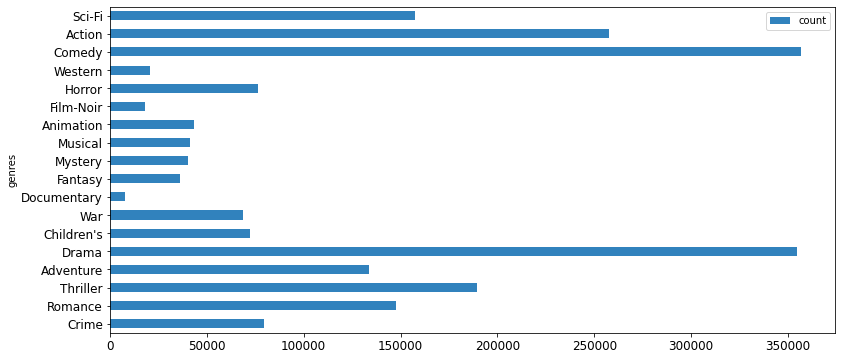

In [ ]:
## lets visualize the above result using Matplotlib library for clear understanding

plot_genres = count_genres.toPandas()
plot_genres.set_index('genres', inplace=True)

plot_genres.plot(kind= 'barh',figsize = (13,6),fontsize=12,colormap='tab20c')


In [ ]:
## lets find out top 10 most rated movies..

top10Rated_fullDF = fullDF.groupBy('movieName')\
                     .agg(func.count('movieName').alias('NUmber_of_ratings')) \
                     .sort(func.col('NUmber_of_ratings').desc())
                                           

top10Rated_fullDF.show(10, truncate=False)

+-----------------------------------------------------+-----------------+
|movieName                                            |NUmber_of_ratings|
+-----------------------------------------------------+-----------------+
|American Beauty (1999)                               |3428             |
|Star Wars: Episode IV - A New Hope (1977)            |2991             |
|Star Wars: Episode V - The Empire Strikes Back (1980)|2990             |
|Star Wars: Episode VI - Return of the Jedi (1983)    |2883             |
|Jurassic Park (1993)                                 |2672             |
|Saving Private Ryan (1998)                           |2653             |
|Terminator 2: Judgment Day (1991)                    |2649             |
|Matrix, The (1999)                                   |2590             |
|Back to the Future (1985)                            |2583             |
|Silence of the Lambs, The (1991)                     |2578             |
+-------------------------------------

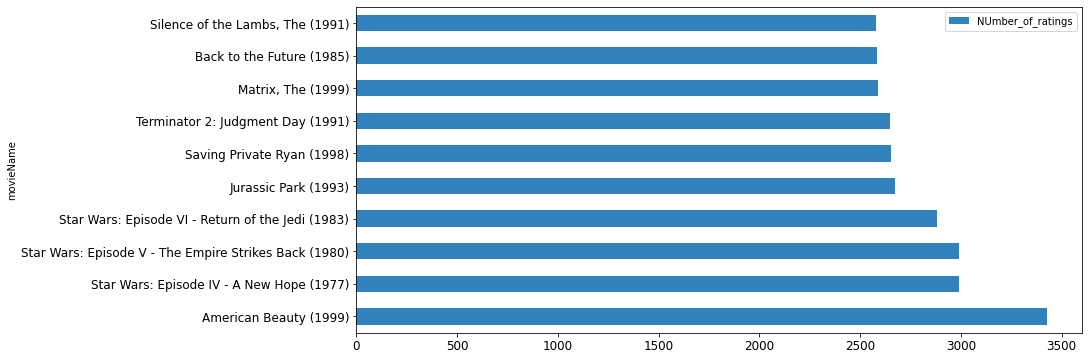

In [ ]:
plot_top10_fullDF = top10Rated_fullDF.limit(10).toPandas()
plot_top10_fullDF.set_index('movieName', inplace=True)

plot_top10_fullDF.plot(kind='barh', figsize = (13,6), fontsize=12, colormap='tab20c')

In [ ]:
# lets find out the most rated movie 'American Beauty (1999)' belong to which genre

fullDF_with_genres.filter(fullDF_with_genres.movieName == 'American Beauty (1999)') \
                            .groupBy('movieName', 'genres') \
                            .agg(func.count('genres')) \
                            .select('movieName', 'genres') \
                            .show(truncate=False)

+----------------------+------+
|movieName             |genres|
+----------------------+------+
|American Beauty (1999)|Drama |
|American Beauty (1999)|Comedy|
+----------------------+------+



In [ ]:
## Minimum and Maximum number of movies rated by One user.

moviesRated_by_oneUser = fullDF \
                         .groupBy('userId') \
                         .agg(func.count('ratings').alias('Total_number_of_ratings')) \
                         .select('userId', 'Total_number_of_ratings') \
                         .sort(func.col('Total_number_of_ratings').desc())
                         
moviesRated_by_oneUser.show(5)

print('Maximum Number of ratings given by one user : {0}'.format(moviesRated_by_oneUser.agg({'Total_number_of_ratings' : 'max'}).collect()[0][0]))

print('Minimum Number of ratings given by one user : {0}'.format(moviesRated_by_oneUser.agg({'Total_number_of_ratings' : 'min'}).collect()[0][0]))

+------+-----------------------+
|userId|Total_number_of_ratings|
+------+-----------------------+
|  4169|                   2314|
|  1680|                   1850|
|  4277|                   1743|
|  1941|                   1595|
|  1181|                   1521|
+------+-----------------------+
only showing top 5 rows

Maximum Number of ratings given by one user : 2314
Minimum Number of ratings given by one user : 20


In [ ]:
popularGenres_by_genderDF = fullDF_with_genres.filter(fullDF_with_genres.ratings >= 4) \
                                              .groupBy(['gender', 'genres'])\
                                              .agg(func.count('genres').alias('NUmber_of_ratings'))\
                                              .orderBy('genres') \
                                              .select('genres', 'gender', 'NUmber_of_ratings')
popularGenres_by_genderDF.show(40,truncate=False)

+-----------+------+-----------------+
|genres     |gender|NUmber_of_ratings|
+-----------+------+-----------------+
|Action     |F     |24705            |
|Action     |M     |114061           |
|Adventure  |M     |56085            |
|Adventure  |F     |14866            |
|Animation  |M     |18863            |
|Animation  |F     |7773             |
|Children's |M     |25172            |
|Children's |F     |12106            |
|Comedy     |F     |54931            |
|Comedy     |M     |142014           |
|Crime      |M     |39234            |
|Crime      |F     |10113            |
|Documentary|M     |4309             |
|Documentary|F     |1407             |
|Drama      |F     |63381            |
|Drama      |M     |165059           |
|Fantasy    |M     |14000            |
|Fantasy    |F     |4714             |
|Film-Noir  |F     |3093             |
|Film-Noir  |M     |10849            |
|Horror     |M     |27555            |
|Horror     |F     |6533             |
|Musical    |F     |8874 

In [ ]:
## Popular genres among men..

top10genres_men = popularGenres_by_genderDF.filter(popularGenres_by_genderDF.gender == 'M')\
                                          .sort(func.col('NUmber_of_ratings').desc())

top10genres_men.show(10, truncate=False)

+---------+------+-----------------+
|genres   |gender|NUmber_of_ratings|
+---------+------+-----------------+
|Drama    |M     |165059           |
|Comedy   |M     |142014           |
|Action   |M     |114061           |
|Thriller |M     |85045            |
|Sci-Fi   |M     |68754            |
|Adventure|M     |56085            |
|Romance  |M     |55047            |
|Crime    |M     |39234            |
|War      |M     |37746            |
|Horror   |M     |27555            |
+---------+------+-----------------+
only showing top 10 rows



In [ ]:
## Popular genres among females..

top10genres_female = popularGenres_by_genderDF.filter(popularGenres_by_genderDF.gender == 'F')\
                                          .sort(func.col('NUmber_of_ratings').desc())

top10genres_female.show(10, truncate=False)

+----------+------+-----------------+
|genres    |gender|NUmber_of_ratings|
+----------+------+-----------------+
|Drama     |F     |63381            |
|Comedy    |F     |54931            |
|Romance   |F     |30452            |
|Action    |F     |24705            |
|Thriller  |F     |23171            |
|Adventure |F     |14866            |
|Sci-Fi    |F     |14443            |
|Children's|F     |12106            |
|Crime     |F     |10113            |
|War       |F     |9796             |
+----------+------+-----------------+
only showing top 10 rows



#### It's surprising to see the Most Popular genres among Male and Female users are Comedy and Drama. These genres are also associated with most of the movies. No wonder the Most rated movie 'American Beauty (1999)' belongs to Comedy/Drama category. Stopping at this point was difficult because there is so much more insights we can extract from this data. But its a good indicator that we have sufficient understanding of the data to begin to build an effective baseline model.

## **Basic Recommendations:**

#### One way to recommend movies is to always recommend the movies with the highest average rating. In this part, we will use Spark to find the name, number of ratings, and the average rating of the 20 movies with the highest average rating and at least 500 reviews because movies with few reviews may not have broad appeal to everyone.

#### From here onwards, we will use ratingsDF and movieNamesDF dataFrames for simplicity reasons.

In [ ]:
## Average rating per movie using ratingsDF dataFrame

movies_with_high_avg = ratingsDF.groupBy('movieId')\
                                .agg(func.count('ratings').alias('Number_of_ratings'), func.round(func.avg('ratings'), 2).alias('Avg_ratings_per_movie')) \
                                .sort(func.col('Avg_ratings_per_movie').desc())

movies_with_high_avg.show(10, truncate=False)
                                

+-------+-----------------+---------------------+
|movieId|Number_of_ratings|Avg_ratings_per_movie|
+-------+-----------------+---------------------+
|3881   |1                |5.0                  |
|1830   |1                |5.0                  |
|3656   |1                |5.0                  |
|3280   |1                |5.0                  |
|3172   |1                |5.0                  |
|787    |3                |5.0                  |
|3607   |1                |5.0                  |
|3382   |1                |5.0                  |
|989    |1                |5.0                  |
|3233   |2                |5.0                  |
+-------+-----------------+---------------------+
only showing top 10 rows



In [ ]:
## Filtering movies with 500 ratings or more

movies_highAvg_500ormoreRatings = movies_with_high_avg.filter(movies_with_high_avg.Number_of_ratings >= 500)
movies_highAvg_500ormoreRatings.show(10, truncate=False)

+-------+-----------------+---------------------+
|movieId|Number_of_ratings|Avg_ratings_per_movie|
+-------+-----------------+---------------------+
|2019   |628              |4.56                 |
|318    |2227             |4.55                 |
|858    |2223             |4.52                 |
|50     |1783             |4.52                 |
|745    |657              |4.52                 |
|527    |2304             |4.51                 |
|1148   |882              |4.51                 |
|904    |1050             |4.48                 |
|1198   |2514             |4.48                 |
|750    |1367             |4.45                 |
+-------+-----------------+---------------------+
only showing top 10 rows



In [ ]:
## joining the movienamesDF to add movie names to each row..

movie_names = movies_highAvg_500ormoreRatings\
              .join(movieNamesDF, movies_highAvg_500ormoreRatings.movieId == movieNamesDF.movieId)\
              .select(movies_highAvg_500ormoreRatings.movieId, movieNamesDF.movieName, movies_highAvg_500ormoreRatings.Number_of_ratings, movies_highAvg_500ormoreRatings.Avg_ratings_per_movie)\
              .sort(func.col('Avg_ratings_per_movie').desc())

movie_names.show(10, truncate=False)            

+-------+-------------------------------------------------------------------+-----------------+---------------------+
|movieId|movieName                                                          |Number_of_ratings|Avg_ratings_per_movie|
+-------+-------------------------------------------------------------------+-----------------+---------------------+
|2019   |Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)|628              |4.56                 |
|318    |Shawshank Redemption, The (1994)                                   |2227             |4.55                 |
|858    |Godfather, The (1972)                                              |2223             |4.52                 |
|50     |Usual Suspects, The (1995)                                         |1783             |4.52                 |
|745    |Close Shave, A (1995)                                              |657              |4.52                 |
|1148   |Wrong Trousers, The (1993)                     

In [ ]:
## Basic statistics of the above movie_names dataFrame

movie_names.describe().show()

+-------+------------------+--------------------+------------------+---------------------+
|summary|           movieId|           movieName| Number_of_ratings|Avg_ratings_per_movie|
+-------+------------------+--------------------+------------------+---------------------+
|  count|               618|                 618|               618|                  618|
|   mean|1832.6699029126214|                null| 962.3171521035599|    3.689255663430419|
| stddev| 1068.586352146532|                null|471.92965000236813|   0.4305720773398214|
|    min|                 1|10 Things I Hate ...|               500|                 2.16|
|    max|              3948|   Young Guns (1988)|              3428|                 4.56|
+-------+------------------+--------------------+------------------+---------------------+



In [ ]:
## Recommending 20 movies with average ratings per movie > 4 and with 500 or more ratings count

recommendedMovies = movie_names.filter(movie_names.Avg_ratings_per_movie >= 4)
                              
recommendedMovies.show(20, truncate=False)

+-------+---------------------------------------------------------------------------+-----------------+---------------------+
|movieId|movieName                                                                  |Number_of_ratings|Avg_ratings_per_movie|
+-------+---------------------------------------------------------------------------+-----------------+---------------------+
|2019   |Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)        |628              |4.56                 |
|318    |Shawshank Redemption, The (1994)                                           |2227             |4.55                 |
|745    |Close Shave, A (1995)                                                      |657              |4.52                 |
|858    |Godfather, The (1972)                                                      |2223             |4.52                 |
|50     |Usual Suspects, The (1995)                                                 |1783             |4.52           

## **Alternating Least Squares (ALS):**

#### In this part, we will use the Apache Spark ML Pipeline implementation of Alternating Least Squares algorithm to recommend movies.

In [ ]:
## spliting the ratings dataset into train, validation and test sets..

seed = 42
(split_60_df, split_a_20_df, split_b_20_df) = ratingsDF.randomSplit([0.6, 0.2, 0.2], seed) 

train_df = split_60_df.cache()
val_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

trainRatio = train_df.count()/ratingsDF.count()
valRatio = val_df.count()/ratingsDF.count()
testRatio = test_df.count()/ratingsDF.count()

print("Total number of ratings : ", ratingsDF.count())
print("Total number of ratings in train_df : ", str(train_df.count()) + ', %.2f' %trainRatio+"%")
print("Total number of ratings in val_df : ", str(val_df.count()) + ", %.2f" %valRatio+"%")
print("Total number of ratings in test_df : ", str(test_df.count()) + ", %.2f" %testRatio+"%")


Total number of ratings :  1000209
Total number of ratings in train_df :  600453, 0.60%
Total number of ratings in val_df :  199724, 0.20%
Total number of ratings in test_df :  200032, 0.20%


In [ ]:
## Build the recommendation model using ALS on the training data
## we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

als = ALS(maxIter=10, regParam=0.1, rank=5, userCol='userId', itemCol='movieId', ratingCol='ratings', coldStartStrategy='drop')
model_als = als.fit(train_df)

In [ ]:
## Run the transform() method on the validation data and output a DataFrame with an additional prediction column that shows the sample of predicted rating

val_pred = model_als.transform(val_df)

val_pred.show(10)

+------+-------+-------+----------+
|userId|movieId|ratings|prediction|
+------+-------+-------+----------+
|  4227|    148|      2| 2.1637135|
|  3829|    148|      2| 2.6677127|
|  2456|    148|      2|   2.76397|
|  3841|    463|      3| 2.3814561|
|  3650|    463|      2|  2.763534|
|    26|    463|      3| 2.5573711|
|  3328|    463|      4|   3.04088|
|  5047|    463|      3| 2.3884087|
|  3032|    463|      4|  3.732343|
|  3709|    463|      3|  2.594493|
+------+-------+-------+----------+
only showing top 10 rows



#### Eventhough many of the predictions are close to the actual ratings the model can use some performance tuning.

In [ ]:
## We will use RegressionEvaluator from SparkMl evaluation metrics to calculate the RMSE of the model

evaluator = RegressionEvaluator(metricName='rmse', labelCol='ratings', predictionCol='prediction')

rmse_als = evaluator.evaluate(val_pred)

print("RMSE : ", str(rmse_als))

RMSE :  0.8842416514584979


## **Improve the Performance of the model using k -fold cross validation**.

In [ ]:
## Create a kfoldALS() function that also trains, runs, and evaluates the model.
## The original data set is split into k data sets.
## Each of the k iterations of the function uses a different data set for testing and the other data sets for training.

def kfoldALS(data, k=3, userCol='userId', itemCol='movieId', ratingCol='ratings', metricName='rmse'):
    evaluations = []        
    weights = [1.0] * k
    splits = ratingsDF.randomSplit(weights)
    for i in range(0, k):      
        testingSet = splits[i]
        trainingSet = spark.createDataFrame(sc.emptyRDD(), ratingsDF.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                trainingSet = trainingSet.union(splits[j])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol, coldStartStrategy='drop')
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol='ratings', predictionCol='prediction')
        evaluation = evaluator.evaluate(predictions)
        #print('Loop {}: {} = {}'.format(i + 1, metricName, evaluation))
        evaluations.append(evaluation)      
    return sum(evaluations) / float(len(evaluations))

In [ ]:
## lets set the folds range from 4 to 10 and run the kfoldALS() function to determine the best value for k.

folds = range(4,11)
rmse_val = []
for i in folds:
  rmse = kfoldALS(ratingsDF, k=i) 
  print("for k = ", str(i) + ', RMSE = {}' .format(rmse))
  rmse_val.append(rmse)

for k =  4, RMSE = 0.8715503930284132
for k =  5, RMSE = 0.8703667486302058
for k =  6, RMSE = 0.8700132464803568
for k =  7, RMSE = 0.8694875818924046
for k =  8, RMSE = 0.8692650521536701
for k =  9, RMSE = 0.8691069717625415
for k =  10, RMSE = 0.8689893453440061


Text(0, 0.5, 'RMSE')

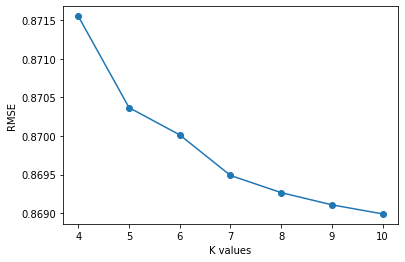

In [ ]:
## plotting the RMSE of all the K values

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(folds, rmse_val, 'o-')
plt.xlabel("K values")
plt.ylabel("RMSE")

#### 10 folds means a training set of 90% of the data, while 4 folds means a training training set of 75% of the data. If we choose a value too small for  k , we will run into the selection bias issue. On the other hand, too big value for  k  means overfitting - high variance and low bias.
#### We will choose K=10, a popular default for Cross Validating our model. The reason for this is studies were performed and k=10  was found to provide good trade-off of low computational cost and low bias in an estimate of model performance.

## **Tuning the ALS Model**

In [ ]:
##The Spark CrossValidator function performs a grid search as well as k-fold cross validation.
## Run the CrossValidator function with multiple values for rank, regParam and maxIter
## we set the coldStartStrategy parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. 
## The evaluation metric will then be computed over the non-NaN data and will be valid.

als_cv = ALS(userCol='userId', itemCol='movieId', ratingCol='ratings', coldStartStrategy='drop')

evaluator = RegressionEvaluator(metricName='rmse', labelCol='ratings', predictionCol='prediction')

paramGrid = ParamGridBuilder().addGrid(als_cv.rank, [4, 8, 12]).addGrid(als_cv.maxIter, [20]).addGrid(als_cv.regParam, [0.05, 0.1, 0.5]).build()

cv = CrossValidator(estimator=als_cv,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=10)

cvModel = cv.fit(train_df)


In [ ]:
## extract the best model from the cvModel
best_model = cvModel.bestModel

#### Best Model and its parameters

In [ ]:
## checking the best parameters from the bestModel

print(type(best_model))

print("Best Rank : ", best_model._java_obj.parent().getRank())
print("Max Iteration : ", best_model._java_obj.parent().getMaxIter())
print("Best RegParam : ", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
Best Rank :  12
Max Iteration :  20
Best RegParam :  0.1


In [ ]:
# Run the tuned model to create a prediction against the validation_df

val_pred_cv = best_model.transform(val_df)

print('The root mean squared error for Validation dataset after tuning is: {}'.format(evaluator.evaluate(val_pred_cv)))

The root mean squared error for Validation dataset after tuning is: 0.8668694032896457


#### Prediction against the Test dataset

In [ ]:
## Finally, lets make a prediction on the test dataset using our tuned model

test_Pred = best_model.transform(test_df)

test_RMSE = evaluator.evaluate(test_Pred)

print("RMSE of Test dataset : {} " . format(test_RMSE))

RMSE of Test dataset : 0.867139156535232 


In [ ]:
## lets check sample of the prediction against the actual value

test_Pred.show(10)

+------+-------+-------+----------+
|userId|movieId|ratings|prediction|
+------+-------+-------+----------+
|  4169|    148|      3| 2.8003232|
|  3539|    148|      3| 3.1331558|
|   216|    148|      2| 2.2855732|
|   482|    148|      2| 2.6051052|
|  4040|    463|      1|  2.229152|
|  2051|    463|      1|  2.377112|
|   721|    463|      4| 3.1592262|
|  4252|    463|      3| 2.2916107|
|  3808|    463|      3|   2.46524|
|  5831|    463|      4| 2.9461637|
+------+-------+-------+----------+
only showing top 10 rows



#### Looking at the RMSE for the results predicted by the model versus the values in the test set is one way to evalute the quality of our model. Another way to evaluate the model is to evaluate the error from a test set where every rating is the average rating for the training set.

In [ ]:
train_avg = train_df.agg(func.avg('ratings')).withColumnRenamed("avg('ratings')", 'avg_train')

avg_train_rating = train_avg.collect()[0][0]

print("Average ratings of the Train dataset is {0}. " .format(avg_train_rating))

test_avg_column = test_df.withColumn('prediction', lit(avg_train_rating))

test_avg_RMSE = evaluator.evaluate(test_avg_column)

print("Test data RMSE value with Train data Average ratings as prediction is {0}. " .format(test_avg_RMSE))



Average ratings of the Train dataset is 3.5819323077742973. 
Test data RMSE value with Train data Average ratings as prediction is 1.118281813691452. 


## **Checking the recommendation for a particular user with ID 1500 using our tuned ALS model** 

In [ ]:
user_id = 1500

## lets sample the movies watched by the user 1500
moviesWatched_user1500 = ratingsDF.filter(ratingsDF.userId == 1500)
moviesWatched_user1500.show(10)

+------+-------+-------+
|userId|movieId|ratings|
+------+-------+-------+
|  1500|   3791|      1|
|  1500|   3793|      3|
|  1500|   2054|      3|
|  1500|   1257|      3|
|  1500|   2997|      5|
|  1500|   1259|      4|
|  1500|   3948|      5|
|  1500|   3949|      5|
|  1500|   1265|      5|
|  1500|    593|      4|
+------+-------+-------+
only showing top 10 rows



In [ ]:
## lets check the Minimum, Maximum and the Average ratings given by the user

moviesWatched_user1500.agg(func.min('ratings'), func.max('ratings'), func.round(func.avg('ratings'),2).alias("avg(ratings)")).show(truncate=False)


+------------+------------+------------+
|min(ratings)|max(ratings)|avg(ratings)|
+------------+------------+------------+
|1           |5           |3.9         |
+------------+------------+------------+



In [ ]:
## lets find out the top10 rated movies by the userId 1500.. for that we need to combine the movies dataframe along with ratings dataframe 
## in order to find out the movieNames and the genres

top10RatedMovies_user1500 = ratingsDF.filter(ratingsDF.userId == 1500)\
                            .join(movieNamesDF, ratingsDF.movieId == movieNamesDF.movieId)\
                            .select(ratingsDF.userId, ratingsDF.movieId, movieNamesDF.movieName, movieNamesDF.genres, ratingsDF.ratings)\
                            .sort(func.col('ratings').desc())                          


top10RatedMovies_user1500.show(10, truncate=False)                           



+------+-------+--------------------------------------------+------------+-------+
|userId|movieId|movieName                                   |genres      |ratings|
+------+-------+--------------------------------------------+------------+-------+
|1500  |3253   |Wayne's World (1992)                        |Comedy      |5      |
|1500  |3897   |Almost Famous (2000)                        |Comedy|Drama|5      |
|1500  |223    |Clerks (1994)                               |Comedy      |5      |
|1500  |2997   |Being John Malkovich (1999)                 |Comedy      |5      |
|1500  |231    |Dumb & Dumber (1994)                        |Comedy      |5      |
|1500  |3949   |Requiem for a Dream (2000)                  |Drama       |5      |
|1500  |3608   |Pee-wee's Big Adventure (1985)              |Comedy      |5      |
|1500  |1292   |Being There (1979)                          |Comedy      |5      |
|1500  |2683   |Austin Powers: The Spy Who Shagged Me (1999)|Comedy      |5      |
|150

In [ ]:
## lets check sample of the ratings dataframe for the Number of movies NOT rated by the user 1500 

movies_notWatchedorRated_user1500 = ratingsDF.filter(ratingsDF.userId != 1500)
movies_notWatchedorRated_user1500.sample(False, 0.01, 0).show(10)

print('Number of movies Not Rated/Watched by the user 1500 : ', movies_notWatchedorRated_user1500.count())

+------+-------+-------+
|userId|movieId|ratings|
+------+-------+-------+
|     1|    919|      4|
|     2|   2943|      4|
|     4|   2692|      5|
|     5|   3267|      4|
|     5|     24|      1|
|     6|     17|      4|
|     9|    590|      5|
|     9|   1356|      3|
|     9|   2890|      5|
|    10|   3438|      3|
+------+-------+-------+
only showing top 10 rows

Number of movies Not Rated/Watched by the user 1500 :  1000094


In [ ]:
## To make a better Recommendations, we need to list of all movies in the movies dataset that user 1500 has not rated so that we can make new movie recommendations 
## based on these movies which user 1500 has not yet watched. We don't want to recommend movies that the user has already rated.
## In order to do this, we will again need to join the ratings and movies datasets. However, unlike the the previous join we did, which was an inner join, 
## this join needs to be an outer join as we want all the movies in the movies dataset that the user has not rated in the ratings dataset. 

movies_notWatched_user1500 = ratingsDF.filter(ratingsDF.userId == 1500)\
                             .join(movieNamesDF, ratingsDF.movieId == movieNamesDF.movieId, 'right')\
                             .filter(ratingsDF.movieId.isNull())\
                             .select(movieNamesDF.movieId, movieNamesDF.movieName, movieNamesDF.genres)\
                             .sort(func.col("movieId"))

movies_notWatched_user1500.show(10, truncate=False)



+-------+----------------------------------+----------------------------+
|movieId|movieName                         |genres                      |
+-------+----------------------------------+----------------------------+
|1      |Toy Story (1995)                  |Animation|Children's|Comedy |
|2      |Jumanji (1995)                    |Adventure|Children's|Fantasy|
|3      |Grumpier Old Men (1995)           |Comedy|Romance              |
|4      |Waiting to Exhale (1995)          |Comedy|Drama                |
|5      |Father of the Bride Part II (1995)|Comedy                      |
|6      |Heat (1995)                       |Action|Crime|Thriller       |
|7      |Sabrina (1995)                    |Comedy|Romance              |
|8      |Tom and Huck (1995)               |Adventure|Children's        |
|9      |Sudden Death (1995)               |Action                      |
|10     |GoldenEye (1995)                  |Action|Adventure|Thriller   |
+-------+-----------------------------

In [ ]:
## lets do a check on the resulting data frame.. The Number of movies not watched by the user (the result of the above dataframe) plus
## the Number of movies rated by the user in the ratings dataframe must be equal to the Total number of movies in the movies dataframe

print('Total number of movies in the Movies dataframe: ', movieNamesDF.count())
print('NUmber of movies Not watched by the user: ', movies_notWatched_user1500.count())
print('Number of movies rated by the user: ', ratingsDF.filter(ratingsDF.userId == 1500).count())

Total number of movies in the Movies dataframe:  3883
NUmber of movies Not watched by the user:  3768
Number of movies rated by the user:  115


In [ ]:
## Now, we have the new dataframe ready (as a result of the Right Outer join) as a input to the model so the Predictions can be made based on it.
## but first we need to add the UserId 1500 for every movie as the model requires UserId ad MovieId to make predictions


movies_df_for_user1500 = movies_notWatched_user1500.withColumn('userId', lit(user_id))
movies_df_for_user1500.show(10, truncate=False)


+-------+----------------------------------+----------------------------+------+
|movieId|movieName                         |genres                      |userId|
+-------+----------------------------------+----------------------------+------+
|1      |Toy Story (1995)                  |Animation|Children's|Comedy |1500  |
|2      |Jumanji (1995)                    |Adventure|Children's|Fantasy|1500  |
|3      |Grumpier Old Men (1995)           |Comedy|Romance              |1500  |
|4      |Waiting to Exhale (1995)          |Comedy|Drama                |1500  |
|5      |Father of the Bride Part II (1995)|Comedy                      |1500  |
|6      |Heat (1995)                       |Action|Crime|Thriller       |1500  |
|7      |Sabrina (1995)                    |Comedy|Romance              |1500  |
|8      |Tom and Huck (1995)               |Adventure|Children's        |1500  |
|9      |Sudden Death (1995)               |Action                      |1500  |
|10     |GoldenEye (1995)   

In [ ]:
## Lets feed this dataframe to our Best ALS model to get Top 10 recommendations for our User 1500

pred_movies_for_user1500 = best_model.transform(movies_df_for_user1500)

als_top10Rec_for_user1500 = pred_movies_for_user1500.select('userId', 'movieId', 'movieName', 'genres', 'prediction')\
                                                    .sort(func.col("prediction").desc())\
                                                    .show(10, truncate=False)



+------+-------+---------------------------------------------------------------------------+------------------+----------+
|userId|movieId|movieName                                                                  |genres            |prediction|
+------+-------+---------------------------------------------------------------------------+------------------+----------+
|1500  |3338   |For All Mankind (1989)                                                     |Documentary       |5.0227456 |
|1500  |858    |Godfather, The (1972)                                                      |Action|Crime|Drama|4.9256268 |
|1500  |1423   |Hearts and Minds (1996)                                                    |Drama             |4.921913  |
|1500  |787    |Gate of Heavenly Peace, The (1995)                                         |Documentary       |4.835946  |
|1500  |2905   |Sanjuro (1962)                                                             |Action|Adventure  |4.8133917 |
|1500  |572    |

In [ ]:
## checking the userId = 1500 from the users dataFrame

userDF.filter(userDF.userId == 1500).show()

+------+------+---+
|userId|gender|age|
+------+------+---+
|  1500|     M| 25|
+------+------+---+



#### Based on the EDA performed on the User's dataFrame, the Top 10 perferences for a male user are 'Comedy', 'Drama', 'Action', 'Adventure', 'Crime', 'Sci-Fi', 'War' etc., By looking at the Model's recommendation, it's clear that the model captures most of the perferences leaving plenty of room for improvement.



## **Prediction for Myself**

#### In this section I want to predict what movies I can recommend to myself. I'll start with 'RecommendedMovies' dataFrame from the Basic Recommendation section to find movies that I am familier with and provide my own ratings for those movies.

In [ ]:
recommendedMovies.show(50, truncate=False)

+-------+---------------------------------------------------------------------------+-----------------+---------------------+
|movieId|movieName                                                                  |Number_of_ratings|Avg_ratings_per_movie|
+-------+---------------------------------------------------------------------------+-----------------+---------------------+
|2019   |Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)        |628              |4.56                 |
|318    |Shawshank Redemption, The (1994)                                           |2227             |4.55                 |
|858    |Godfather, The (1972)                                                      |2223             |4.52                 |
|50     |Usual Suspects, The (1995)                                                 |1783             |4.52                 |
|745    |Close Shave, A (1995)                                                      |657              |4.52           

In [ ]:
#lets check the minimum userId from the ratings dataFrame

check_id = ratingsDF.agg(func.min('userId')).show()

+-----------+
|min(userId)|
+-----------+
|          1|
+-----------+



In [ ]:
## Since the UserId from the ratings dataFrame starts with 1, I'll use userId = 0 for myself and create a dataFrame with a userId, the movieId(the movies I picked)
## and my own ratings for those movies

my_userId = 0

my_rated_movies = [
                   (my_userId, 2019, 5),
                   (my_userId, 858, 5),
                   (my_userId, 527, 4),
                   (my_userId, 1198, 5),
                   (my_userId, 260, 3),
                   (my_userId, 2762, 4),
                   (my_userId, 1204, 5),
                   (my_userId, 1262, 5),
                   (my_userId, 1221, 4),
                   (my_userId, 2028, 5),
                   (my_userId, 1136, 2),
                   (my_userId, 2324, 4),
                   (my_userId, 2571, 3),
                   (my_userId, 1197, 2),
                   (my_userId, 541, 4)
                ]

my_ratings_df = spark.createDataFrame(my_rated_movies, ratingsDF.schema)

my_ratings_df.show(10)


+------+-------+-------+
|userId|movieId|ratings|
+------+-------+-------+
|     0|   2019|      5|
|     0|    858|      5|
|     0|    527|      4|
|     0|   1198|      5|
|     0|    260|      3|
|     0|   2762|      4|
|     0|   1204|      5|
|     0|   1262|      5|
|     0|   1221|      4|
|     0|   2028|      5|
+------+-------+-------+
only showing top 10 rows



In [ ]:
my_ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- ratings: integer (nullable = true)



In [ ]:
## lets combine my_ratings_df dataFrame to the originl train_df..

train_my_ratings_df = train_df.unionAll(my_ratings_df)
train_my_ratings_df.sort(func.col('userId')).show()

+------+-------+-------+
|userId|movieId|ratings|
+------+-------+-------+
|     0|   2324|      4|
|     0|   1204|      5|
|     0|   1136|      2|
|     0|    527|      4|
|     0|   2762|      4|
|     0|   1221|      4|
|     0|   2028|      5|
|     0|   2571|      3|
|     0|   1197|      2|
|     0|   2019|      5|
|     0|    858|      5|
|     0|   1198|      5|
|     0|    260|      3|
|     0|   1262|      5|
|     0|    541|      4|
|     1|   1961|      5|
|     1|   1287|      5|
|     1|   1836|      5|
|     1|   2321|      3|
|     1|   2028|      5|
+------+-------+-------+
only showing top 20 rows



In [ ]:
## checkpoints to see whether the dataFrames merged correctly.

check_user = train_my_ratings_df.filter(train_my_ratings_df.userId == 0)
check_user.show(5)

print("Count of userId = 0 is {0}".format(check_user.count()))

print('The train_my_ratings_df dataFrame has {0} many ratings than the original train_df. ' .format(train_my_ratings_df.count() - train_df.count()))

+------+-------+-------+
|userId|movieId|ratings|
+------+-------+-------+
|     0|   2019|      5|
|     0|    858|      5|
|     0|    527|      4|
|     0|   1198|      5|
|     0|    260|      3|
+------+-------+-------+
only showing top 5 rows

Count of userId = 0 is 15
The train_my_ratings_df dataFrame has 15 many ratings than the original train_df. 


In [ ]:
## Prediction for movies that I've not watched/rated

movies_Notwatched_user0 = train_my_ratings_df.filter(train_my_ratings_df.userId == 0) \
                                             .join(movieNamesDF, train_my_ratings_df.movieId == movieNamesDF.movieId, 'right') \
                                             .filter(train_my_ratings_df.movieId.isNull())\
                                             .select(movieNamesDF.movieId, movieNamesDF.movieName, movieNamesDF.genres)\
                                             .sort(func.col('movieId'))

movies_Notwatched_user0.show(10, truncate=False)

+-------+----------------------------------+----------------------------+
|movieId|movieName                         |genres                      |
+-------+----------------------------------+----------------------------+
|1      |Toy Story (1995)                  |Animation|Children's|Comedy |
|2      |Jumanji (1995)                    |Adventure|Children's|Fantasy|
|3      |Grumpier Old Men (1995)           |Comedy|Romance              |
|4      |Waiting to Exhale (1995)          |Comedy|Drama                |
|5      |Father of the Bride Part II (1995)|Comedy                      |
|6      |Heat (1995)                       |Action|Crime|Thriller       |
|7      |Sabrina (1995)                    |Comedy|Romance              |
|8      |Tom and Huck (1995)               |Adventure|Children's        |
|9      |Sudden Death (1995)               |Action                      |
|10     |GoldenEye (1995)                  |Action|Adventure|Thriller   |
+-------+-----------------------------

In [ ]:
## checkpoint..
print("NUmber of movies in movieNamesDF {0}." .format(movieNamesDF.count())) 
print('Movies Not watched by user 0 {0}' . format(movies_Notwatched_user0.count()))
print('movies rated by user 0 {0}' . format(train_my_ratings_df.filter(train_my_ratings_df.userId == 0).count()))

NUmber of movies in movieNamesDF 3883.
Movies Not watched by user 0 3868
movies rated by user 0 15


In [ ]:
## Train the ALS model again with my ratings added dataFrame and the parameters we got from tuned ALS model

my_alsModel = ALS(rank=12, maxIter=20, regParam=0.1, userCol='userId', itemCol='movieId', seed=42, ratingCol='ratings', coldStartStrategy='drop')

In [ ]:
my_ratings_Model = my_alsModel.fit(train_my_ratings_df)

In [ ]:
## Run the model against the test_df

my_ratings_test_pred = my_ratings_Model.transform(test_df)

In [ ]:
print('RMSE of my_ratings_test_pred dataFrame is {0} ' . format(evaluator.evaluate(my_ratings_test_pred)))

RMSE of my_ratings_test_pred dataFrame is 0.8674488472335011 


In [ ]:
my_rated_movieIds = [x[1] for x in my_rated_movies]
my_rated_movieIds

[2019,
 858,
 527,
 1198,
 260,
 2762,
 1204,
 1262,
 1221,
 2028,
 1136,
 2324,
 2571,
 1197,
 541]

In [ ]:
my_Notrated_movies_df = movieNamesDF.filter(~ movieNamesDF.movieId.isin(my_rated_movieIds))
my_Notrated_movies_df.show(10, truncate=False)

+-------+----------------------------------+----------------------------+
|movieId|movieName                         |genres                      |
+-------+----------------------------------+----------------------------+
|1      |Toy Story (1995)                  |Animation|Children's|Comedy |
|2      |Jumanji (1995)                    |Adventure|Children's|Fantasy|
|3      |Grumpier Old Men (1995)           |Comedy|Romance              |
|4      |Waiting to Exhale (1995)          |Comedy|Drama                |
|5      |Father of the Bride Part II (1995)|Comedy                      |
|6      |Heat (1995)                       |Action|Crime|Thriller       |
|7      |Sabrina (1995)                    |Comedy|Romance              |
|8      |Tom and Huck (1995)               |Adventure|Children's        |
|9      |Sudden Death (1995)               |Action                      |
|10     |GoldenEye (1995)                  |Action|Adventure|Thriller   |
+-------+-----------------------------

In [ ]:
print(my_Notrated_movies_df.count())

3868


In [ ]:
my_unrated_movies_df = my_Notrated_movies_df.withColumn('userId', lit(my_userId))
my_unrated_movies_df.show(5, truncate=False)

+-------+----------------------------------+----------------------------+------+
|movieId|movieName                         |genres                      |userId|
+-------+----------------------------------+----------------------------+------+
|1      |Toy Story (1995)                  |Animation|Children's|Comedy |0     |
|2      |Jumanji (1995)                    |Adventure|Children's|Fantasy|0     |
|3      |Grumpier Old Men (1995)           |Comedy|Romance              |0     |
|4      |Waiting to Exhale (1995)          |Comedy|Drama                |0     |
|5      |Father of the Bride Part II (1995)|Comedy                      |0     |
+-------+----------------------------------+----------------------------+------+
only showing top 5 rows



In [ ]:
pred_for_my_unrated_movies = my_ratings_Model.transform(my_unrated_movies_df)
pred_for_my_unrated_movies.show(10, truncate=False)

+-------+--------------------------------+--------------------------------+------+----------+
|movieId|movieName                       |genres                          |userId|prediction|
+-------+--------------------------------+--------------------------------+------+----------+
|148    |Awfully Big Adventure, An (1995)|Drama                           |0     |2.4413009 |
|463    |Guilty as Sin (1993)            |Crime|Drama|Thriller            |0     |2.548442  |
|471    |Hudsucker Proxy, The (1994)     |Comedy|Romance                  |0     |2.5042772 |
|496    |What Happened Was... (1994)     |Comedy|Drama|Romance            |0     |3.290371  |
|833    |High School High (1996)         |Comedy                          |0     |1.3843108 |
|1088   |Dirty Dancing (1987)            |Musical|Romance                 |0     |3.0252626 |
|1238   |Local Hero (1983)               |Comedy                          |0     |3.7233143 |
|1342   |Candyman (1992)                 |Horror            

In [ ]:
## My movie prediction for Myself with 500 or more ratings per movie
myPredMoviesDF = pred_for_my_unrated_movies\
                                          .join(movie_names, pred_for_my_unrated_movies.movieId == movie_names.movieId) \
                                          .select('userId', pred_for_my_unrated_movies.movieId, pred_for_my_unrated_movies.movieName, pred_for_my_unrated_movies.genres, movie_names.Number_of_ratings, movie_names.Avg_ratings_per_movie) \
                                          .sort(func.col('Avg_ratings_per_movie').desc())

myPredMoviesDF.show(10, truncate=False)

+------+-------+---------------------------------------------------------------------------+-------------------------+-----------------+---------------------+
|userId|movieId|movieName                                                                  |genres                   |Number_of_ratings|Avg_ratings_per_movie|
+------+-------+---------------------------------------------------------------------------+-------------------------+-----------------+---------------------+
|0     |318    |Shawshank Redemption, The (1994)                                           |Drama                    |2227             |4.55                 |
|0     |50     |Usual Suspects, The (1995)                                                 |Crime|Thriller           |1783             |4.52                 |
|0     |745    |Close Shave, A (1995)                                                      |Animation|Comedy|Thriller|657              |4.52                 |
|0     |1148   |Wrong Trousers, The (1993)    

## **Recommending Movies using ALS built-in functions**

In [ ]:
## Generate Top 5 movie recommendation for each user using best ALS model.. Here, we sample for 10 users

als_user_recommendation = best_model.recommendForAllUsers(5)
als_user_recommendation.sample(False,0.01,0).show(10)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   463|[{858, 4.1277027}...|
|  2488|[{572, 5.6006413}...|
|  2622|[{572, 5.53809}, ...|
|  1157|[{572, 5.466335},...|
|  4612|[{572, 4.67222}, ...|
|   918|[{572, 4.5451818}...|
|  1417|[{572, 5.0271783}...|
|  4181|[{572, 5.146816},...|
|  5452|[{787, 4.4129868}...|
|  2047|[{572, 4.9133263}...|
+------+--------------------+
only showing top 10 rows



In [ ]:
## In the above dataFrame the recommendations are stored in the array format with (movieId, ratings). 
## lets explode the array to check the sample of recommendations for each user..

als_user_recommendation = als_user_recommendation.withColumn('recExplode', explode('recommendations')).select('userId', col('recExplode.movieId'), col('recExplode.rating'))
als_user_recommendation.show(10)

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|  1580|    572| 4.407517|
|  1580|   2512|4.3248696|
|  1580|    759| 4.319742|
|  1580|   1423| 4.294054|
|  1580|    666| 4.174753|
|  4900|    572|6.4347777|
|  4900|   2197|5.4246297|
|  4900|   3050|5.3616977|
|  4900|   3808|5.2970705|
|  4900|    213|5.2941337|
+------+-------+---------+
only showing top 10 rows



#### Do these recommendations make sense?. Lets check for userId 1580

In [ ]:
als_user_recommendation.filter(als_user_recommendation.userId == 1580) \
                       .join(movieNamesDF, als_user_recommendation.movieId == movieNamesDF.movieId)\
                       .select(als_user_recommendation.userId, als_user_recommendation.movieId, movieNamesDF.movieName, movieNamesDF.genres, als_user_recommendation.rating) \
                       .sort(func.col('rating').desc()) \
                       .show(truncate=False)

+------+-------+-------------------------------------------------+-----------+---------+
|userId|movieId|movieName                                        |genres     |rating   |
+------+-------+-------------------------------------------------+-----------+---------+
|1580  |572    |Foreign Student (1994)                           |Drama      |4.407517 |
|1580  |2512   |Ballad of Narayama, The (Narayama Bushiko) (1982)|Drama      |4.3248696|
|1580  |759    |Maya Lin: A Strong Clear Vision (1994)           |Documentary|4.319742 |
|1580  |1423   |Hearts and Minds (1996)                          |Drama      |4.294054 |
|1580  |666    |All Things Fair (1996)                           |Drama      |4.174753 |
+------+-------+-------------------------------------------------+-----------+---------+



In [ ]:
userDF.filter(userDF.userId == 1580).show()

+------+------+---+
|userId|gender|age|
+------+------+---+
|  1580|     F| 18|
+------+------+---+



#### Based on the EDA performed on the User's dataFrame, the Top 10 perferences for a female user are 'Comedy', 'Drama', 'Romance', 'Action' etc., By looking at the Model's recommendation, it's clear that the model captures some of the perferences leaving plenty of room for improvement.

In [ ]:
## Generate Top 10 user recommendations for each movie

movieRec = best_model.recommendForAllItems(10)
movieRec.sample(False, 0.01, 0).show(10)


+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1645|[{3902, 4.875489}...|
|   3913|[{870, 5.3965898}...|
|    898|[{1071, 5.2421684...|
|   3306|[{5589, 5.6135764...|
|   2342|[{2867, 5.8309693...|
|    385|[{2869, 5.2642684...|
|    319|[{446, 4.855999},...|
|   3140|[{1445, 5.4293613...|
|   2363|[{2867, 4.988036}...|
|   2852|[{3902, 4.7067833...|
+-------+--------------------+
only showing top 10 rows



In [ ]:
## generate top 5 movie recommendations for a specified set of users

user_subset = ratingsDF.select(als.getUserCol()).distinct().limit(5)
usersubsetRecs = best_model.recommendForUserSubset(user_subset, 5)

usersubsetRecs.show()




+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[{3338, 4.8348346...|
|   463|[{858, 4.1277027}...|
|   833|[{572, 5.3826056}...|
|   496|[{572, 5.519216},...|
|   148|[{572, 5.7716823}...|
+------+--------------------+



In [ ]:
## generate top 5 user recommendations for a specified set of movies

movie_subset = ratingsDF.select(als.getItemCol()).distinct().limit(5)
moviesubsetRecs = best_model.recommendForItemSubset(movie_subset, 5)

moviesubsetRecs.show()



+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1580|[{2867, 5.445257}...|
|   3175|[{2867, 5.3659773...|
|   2366|[{2867, 5.0100574...|
|   1088|[{4173, 4.947901}...|
|   1959|[{2673, 4.9765763...|
+-------+--------------------+

